# ML-7. Оптимизация гиперпараметров модели  

## ПРОГНОЗИРОВАНИЕ БИОЛОГИЧЕСКОГО ОТВЕТА

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).  

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [65]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Подготовка данных

In [66]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Смотрим на сбарансированность классов

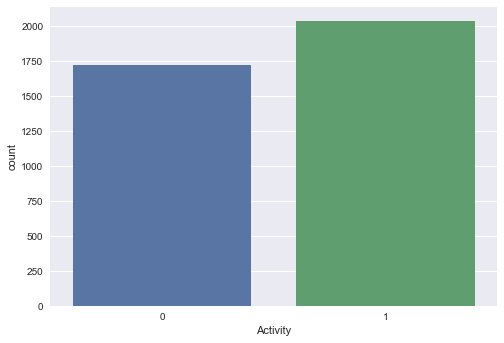

In [67]:
sns.countplot(data=data, x='Activity');

Классы не критично отличаются по количеству наблюдений.

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [68]:
X = data.drop(['Activity'], axis = 1)
y = data['Activity']

In [69]:
# разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

### Обучение

In [70]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# списки для хранения метрик
log_score_train = []
log_score_test = []
log_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
log_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


In [71]:
#Создаём объект класса RandomForestClassifier
rf = ensemble.RandomForestClassifier(
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)
 
#Делаем предсказание класса
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
#Выводим отчёт о метриках
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# списки для хранения метрик
rf_score_train = []
rf_score_test = []
rf_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
rf_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


### Подбор гиперпараметров

#### GridSeachCV

Модель логистической регрессии

In [72]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'f1'
); 
%time grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

log_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
log_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

CPU times: user 15.9 s, sys: 1.98 s, total: 17.9 s
Wall time: 56.6 s
f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


Модель случайного леса

In [73]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}


grid_search_rf = GridSearchCV(
    estimator= rf, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_rf.fit(X_train, y_train)
 
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

rf_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
rf_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

CPU times: user 4.89 s, sys: 813 ms, total: 5.71 s
Wall time: 5min 35s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


#### RandomizedSearchCV

Модель логистической регрессии

In [74]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator= log_reg, 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train);

y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

log_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
log_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

CPU times: user 8.53 s, sys: 132 ms, total: 8.66 s
Wall time: 2min 44s
f1_score на обучающем наборе: 0.86
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}


Модель случайного леса

In [75]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]

param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

random_search = RandomizedSearchCV(
    estimator= rf, 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train);

y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

rf_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
rf_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

CPU times: user 3.13 s, sys: 88.3 ms, total: 3.22 s
Wall time: 15.8 s
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 411, 'max_features': 'sqrt', 'max_depth': 13}


#### Hyperopt

In [76]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

Модель случайного леса

In [77]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'max_depth' : hp.quniform('max_depth', 3, 20, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [78]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [79]:
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:28<00:00,  1.44s/trial, best loss: -0.9616087751371116]
Наилучшие значения гиперпараметров {'max_depth': 14.0, 'min_samples_leaf': 3.0, 'n_estimators': 159.0}


In [80]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

rf_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
rf_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.80


### Optuna

In [81]:
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score



In [82]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-12-05 15:32:12,353] A new study created in memory with name: RandomForestClassifier
[I 2022-12-05 15:32:13,612] Trial 0 finished with value: 0.8944326133252206 and parameters: {'n_estimators': 190, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8944326133252206.
[I 2022-12-05 15:32:14,997] Trial 1 finished with value: 0.9476885644768857 and parameters: {'n_estimators': 191, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9476885644768857.
[I 2022-12-05 15:32:15,848] Trial 2 finished with value: 0.9457886676875957 and parameters: {'n_estimators': 119, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9476885644768857.
[I 2022-12-05 15:32:16,931] Trial 3 finished with value: 0.9327654396105872 and parameters: {'n_estimators': 152, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9476885644768857.
[I 2022-12-05 15:32:18,178] Trial 4 finished with value: 0.9908031882280809 and parameters: {'n

In [83]:

model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

rf_score_train.append(round(metrics.f1_score(y_train, y_train_pred),2))
rf_score_test.append(round(metrics.f1_score(y_test, y_test_pred),2))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.80


# Результаты

In [84]:
# так как для логистической регрессии не проводит подбор параметров продвинутыми методами, добавили 0 в списки значений метрики
log_score_train.extend([0,0])
log_score_test.extend([0,0])

In [88]:
# выведем все полученные значения метрики
dict = {'log_score_train' : log_score_train, 'log_score_test' : log_score_test, 
        'rf_score_train' : rf_score_train, 'rf_score_test' : rf_score_test}
result = pd.DataFrame(dict, index=['base', 'GridSeachCV', 'RandomizedSearchCV', 'Hyperopt', 'Optuna'])
result

,log_score_train,log_score_test,rf_score_train,rf_score_test
base,0.89,0.78,1.00,0.80
GridSeachCV,0.89,0.78,0.99,0.81
RandomizedSearchCV,0.86,0.79,0.98,0.81
Hyperopt,0.00,0.00,0.96,0.80
Optuna,0.00,0.00,0.99,0.80
